In [1]:
import sys
sys.path.append('../')

import numpy as np
import matplotlib.pyplot as plt
import sinter
from stim_surface_code.memory import MemoryPatch
from stim_surface_code.stability import StabilityPatch
from stim_surface_code import noise

In [2]:
m = MemoryPatch(5, 5, 5)
m

--------------------------------------------------------
|    |    |X 25|    |    |    |X 26|    |    |    |    |
----------+----+--------------+----+--------------------
|    |   0|    |   1|    |   2|    |   3|    |   4|    |
----------+----+----+----+----+----+----+----+----+-----
|    |    |Z 27|    |X 28|    |Z 29|    |X 30|    |Z 31|
----------+----+----+----+----+----+----+----+----+-----
|    |   5|    |   6|    |   7|    |   8|    |   9|    |
-----+----+----+----+----+----+----+----+----+----------
|Z 32|    |X 33|    |Z 34|    |X 35|    |Z 36|    |    |
-----+----+----+----+----+----+----+----+----+----------
|    |L 10|    |L 11|    |L 12|    |L 13|    |L 14|    |
----------+----+----+----+----+----+----+----+----+-----
|    |    |Z 37|    |X 38|    |Z 39|    |X 40|    |Z 41|
----------+----+----+----+----+----+----+----+----+-----
|    |  15|    |  16|    |  17|    |  18|    |  19|    |
-----+----+----+----+----+----+----+----+----+----------
|Z 42|    |X 43|    |Z 44|    |

In [3]:
# 10x better noise vals than Google's device
noise_params = noise.GoogleNoiseParams.improve(10)
noise_params.error_stdevs = {k: 0 for k in noise_params.error_stdevs}
print(noise_params.error_means)

{'T1': 0.0002, 'T2': 0.00030000000000000003, 'gate1_err': 9.015368548802825e-07, 'gate2_err': 0.00035424042547487725, 'readout_err': 0.0002}


In [4]:
noise_params.set_patch_err_vals(m)

In [5]:
# We can use Sinter for a single task...
m.count_logical_errors(use_sinter=True)

(0.000882, 10000000)

In [6]:
# ...or we can use Sinter for a batch of tasks
mem_tasks = []
ps = np.geomspace(1e-3,3/4,10)
for d in [3,5,7,9]:
    m = MemoryPatch(d, d, d)
    for p in ps:
        noise_params = noise.NoiseParams(
            baseline_error_means = {
                'T1': np.inf,
                'T2': np.inf,
                'gate1_err': p,
                'gate2_err': p,
                'readout_err': p,
            }
        )
        noise_params.set_patch_err_vals(m)
        mem_tasks.append(m.get_sinter_task(
            task_kwargs={
                'json_metadata': {'d': d, 'p': p},
                'decoder': 'pymatching',
            }
        ))

In [7]:
mem_collected_stats = sinter.collect(tasks=mem_tasks, num_workers=6, max_shots=10**6, max_errors=500)

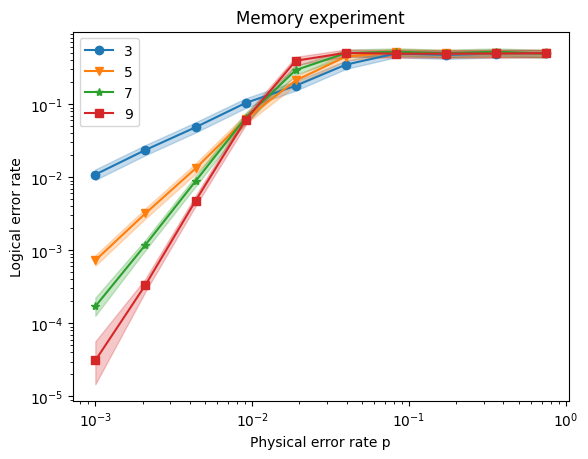

In [8]:
fig,ax = plt.subplots()
sinter.plot_error_rate(ax=ax, stats=mem_collected_stats, x_func=lambda stats: stats.json_metadata['p'], group_func=lambda stats: stats.json_metadata['d'])
ax.legend()
ax.loglog()
plt.title('Memory experiment')
plt.xlabel('Physical error rate p')
plt.ylabel('Logical error rate')
plt.show()

In [9]:
# stability
stab_tasks = []
ps = np.geomspace(1e-3,3/4,10)
for d in [4,6,8,10]:
    s = StabilityPatch(d, d, d)
    for p in ps:
        noise_params = noise.NoiseParams(
            baseline_error_means = {
                'T1': np.inf,
                'T2': np.inf,
                'gate1_err': p,
                'gate2_err': p,
                'readout_err': p,
            }
        )
        noise_params.set_patch_err_vals(s)
        stab_tasks.append(s.get_sinter_task(
            task_kwargs={
                'json_metadata': {'d': d, 'p': p},
                'decoder': 'pymatching',
            }
        ))

In [10]:
stab_collected_stats = sinter.collect(tasks=stab_tasks, num_workers=6, max_shots=10**6, max_errors=500)

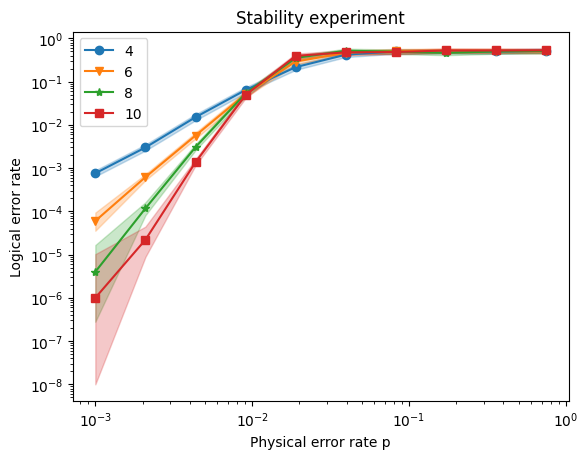

In [11]:
fig,ax = plt.subplots()
sinter.plot_error_rate(ax=ax, stats=stab_collected_stats, x_func=lambda stats: stats.json_metadata['p'], group_func=lambda stats: stats.json_metadata['d'])
ax.legend()
ax.loglog()
plt.title('Stability experiment')
plt.xlabel('Physical error rate p')
plt.ylabel('Logical error rate')
plt.show()